In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

In [2]:
import tqdm

In [3]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom

import lal
import lalsimulation as lalsim

from scrinet.interfaces import lalutils

In [4]:
from scrinet.greedy import greedyrb
from scrinet.surrogate import surrogate

# Data acquisition

We need a function that we can call to
generate data in a uniform way.

We will use this to generate the data for:
 - the seed basis
 - additional training sets and
 - validation sets

In [6]:
def gen_1d_massratio_data(q_array, M, deltaT=1/1024., f_min=10,
                         approximant=lalsim.SEOBNRv4_opt, inclination=0,
                          t_min=-10000, t_max=100, npts=5000
                         ):

    new_times = np.linspace(t_min, t_max, npts)
    
    data = []
    coords = []
    
    for q in q_array:
        m1, m2 = phenom.m1_m2_M_q(M, q)
        pp = dict(m1=m1, m2=m2, deltaT=deltaT,
                  f_min=f_min,
                  inclination=inclination,
                  approximant=approximant
                 )
        p = lalutils.gen_td_wf_params(**pp)
        t, amp, phase = lalutils.gen_td_wf(p, t_min=t_min, t_max=t_max)
              
        iamp = IUS(t, amp)
        iphase = IUS(t, phase)
        
        # interpolate around peak
#         max_amp_idx = amp.argmax()
#         tpeak = t[max_amp_idx]
#         t_fine = np.linspace(tpeak-10, tpeak+10,1000)
#         amp_fine = iamp(t_fine)
#         tpeak = t_fine[amp_fine.argmax()]
        
        
#         iamp = IUS(t-tpeak, amp)
#         iphase = IUS(t-tpeak, phase)
        amp = iamp(new_times)
        phase = iphase(new_times)

        
        tshift = lalutils.peak_align_shift(new_times, amp)
        amp = lalutils.peak_align_interp(new_times, amp, tshift)
        phase = lalutils.peak_align_interp(new_times, phase, tshift)

        
        d = {"t":new_times, "amp":amp, "phase":phase}
        
        data.append(d)
        coords.append([q])
    
    n_t_points = len(new_times)
    n_waveforms = len(data)
    ts_amp = np.zeros(shape=(n_waveforms, n_t_points))
    ts_phase = np.zeros(shape=(n_waveforms, n_t_points))
    
    
    
    for i in range(n_waveforms):
        ts_amp[i] = data[i]['amp'] / phenom.eta_from_q(coords[i][0]) / 1e5
        ts_phase[i] = data[i]['phase'] - data[i]['phase'][0]
        
    return new_times, ts_amp, ts_phase, np.array(coords)

# condensed code

In [7]:
def build_surrogate_iterative(
    amp_or_phase,
    qmin=1,
    qmax=10,
    qnpts=10,
    mtotal=100,
    nvalidation_points=100,
    iterate_surrogate_error=True,
    max_iter=5,
    sur_model_error_tol=2,
    initial_greedy_tol=1e-3,
    iterated_greedy_tol=1e-12,
    fit_method='lr'
):
    """
    qnpts: initial number of points to check seed basis
    nvalidation_points: number of points to validate the model
    
    
    iterate_surrogate_error=True
        if True then will iterate using surrogate error in a second greedy step
        if False then will set max_iter to 1 so that it doesn't iterate
    max_iter:
        max_iter for surrogate iteration greedy step
    sur_model_error_tol:
        error tolerance for 2nd greedy step
    """
    seed_x, seed_ts_amp, seed_ts_phase, seed_ts_coords = gen_1d_massratio_data(np.linspace(qmin, qmax, 3), mtotal)
    # Make integration rule

    int_range = [seed_x[0], seed_x[-1]]
    int_num = len(seed_x)

    integration = greedyrb.Riemann(int_range, num=int_num)
    x = integration.nodes  # Define x for convenience
    
    sur = surrogate.Surrogate(integration)
    
    if amp_or_phase == "amp":
        seed_ts = seed_ts_amp
    elif amp_or_phase == "phase":
        seed_ts = seed_ts_phase
        
    sur.build_seed_basis(ts=seed_ts, ts_coords=seed_ts_coords)
    
    # check seed basis and add points
    _, ts_amp, ts_phase, ts_coords = gen_1d_massratio_data(np.random.uniform(qmin, qmax, qnpts), mtotal)
    
    if amp_or_phase == "amp":
        ts = ts_amp
    elif amp_or_phase == "phase":
        ts = ts_phase
    
    if iterate_surrogate_error == False:
        # don't iterate
        max_iter = 1
    else:
        print("iterating over surrogate error")
        
    for i in range(max_iter):
        print(f"iteration = {i}")

        if i == 0:
            greedy_tol = initial_greedy_tol
            
        else:
            greedy_tol = iterated_greedy_tol
            ts = vts_worst.reshape(1,-1)
            ts_coords = vts_coords_worst.reshape(1,-1)
            
        sur.run_greedy_sweep(ts, ts_coords, verbose=True, greedy_tol=greedy_tol)

        # build eim
        # eim needs to be built from training_set at the greedy points
        _, ts_amp, ts_phase, _ = gen_1d_massratio_data(sur.grb.greedy_points.ravel(), mtotal)
        if amp_or_phase == "amp":
            ts = ts_amp
        elif amp_or_phase == "phase":
            ts = ts_phase 
        sur.build_eim(ts)

        # fit_eim
        X = sur.grb.greedy_points.copy()
        X[:,0] = np.log(X[:,0])
        y = sur.grb.eim.data
        sur.fit_eim(X, y, method=fit_method, maxdegs=[4], max_deg_total=4)

        print(f"total number of greedy points = {sur.grb.nbasis}")

        # now validate
        _, vts_amp, vts_phase, vts_coords = gen_1d_massratio_data(np.random.uniform(qmin, qmax, nvalidation_points), mtotal)
        if amp_or_phase == "amp":
            vts = vts_amp
        elif amp_or_phase == "phase":
            vts = vts_phase 

        model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
        worst_error = model_errors[worst_error_index]
        print(f"worst error = {worst_error}")
        print(f"worst case = {worst_case}")

        plt.figure()
        plt.scatter(vts_coords, model_errors)
        plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
        plt.show()
        plt.close()

        vts_worst = vts[worst_error_index]
        vts_coords_worst = vts_coords[worst_error_index]

        

        # on an iteration, check if we have reached the tolerance
        if worst_error <= sur_model_error_tol:
            print(f"worst error = {worst_error}")
            print(f"worst sur_model_error_tol = {sur_model_error_tol}")
            print("tolerance reached")
            print(f"total number of greedy points = {sur.grb.nbasis}")
            break
    
    return x, sur

In [8]:
mtotal=60

building seed basis
iterating over surrogate error
iteration = 0
tolerance reached. exiting


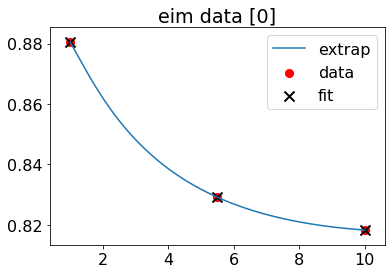

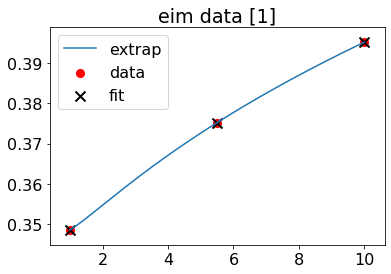

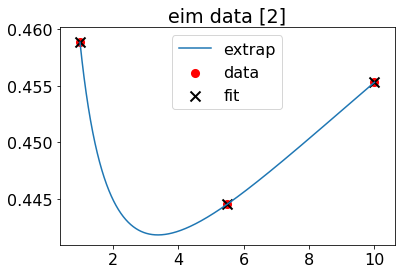

total number of greedy points = 3
worst error = 0.006136617543025467
worst case = [2.16216138]


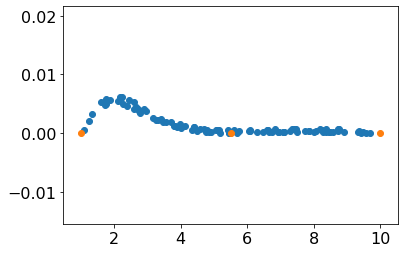

worst error = 0.006136617543025467
worst sur_model_error_tol = 2
tolerance reached
total number of greedy points = 3


In [9]:
amp_x, amp_sur = build_surrogate_iterative(
    amp_or_phase="amp",
    qmin=1,
    qmax=10,
    qnpts=10,
    mtotal=mtotal,
    nvalidation_points=100,
    iterate_surrogate_error=True,
    max_iter=5,
    sur_model_error_tol=2,
    initial_greedy_tol=1e-3,
    iterated_greedy_tol=1e-12,
    fit_method='lr'
)

building seed basis
iterating over surrogate error
iteration = 0
step = 0, error = 1.060730815331981
step = 1, error = 0.03597559933779597
step = 2, error = 0.007996733301423139
tolerance reached. exiting


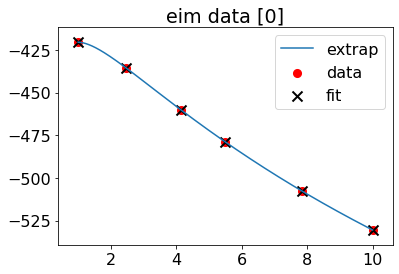

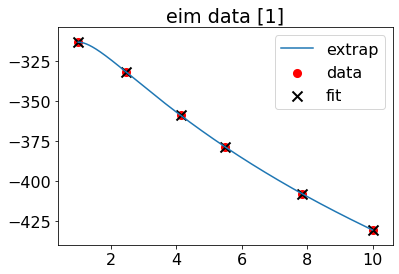

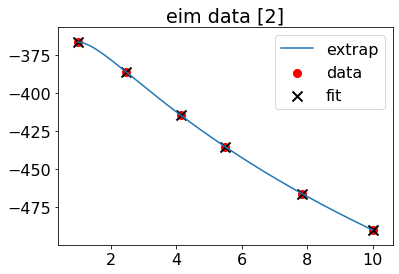

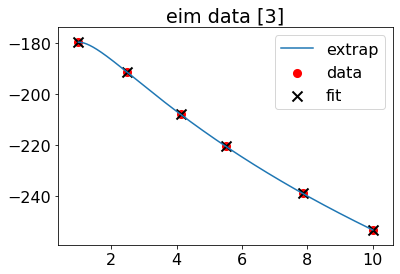

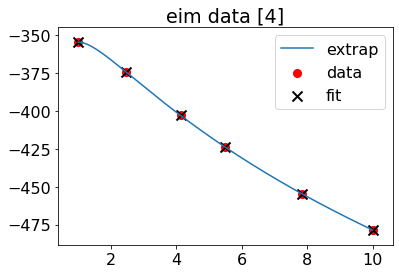

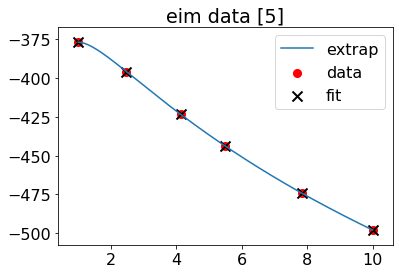

total number of greedy points = 6
worst error = 2.3395970859189776
worst case = [1.27850769]


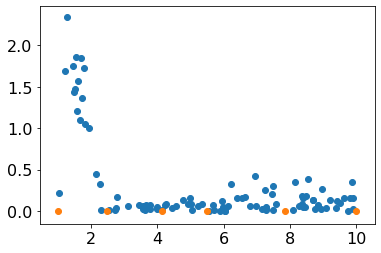

iteration = 1
step = 0, error = 3.939391333545057e-05


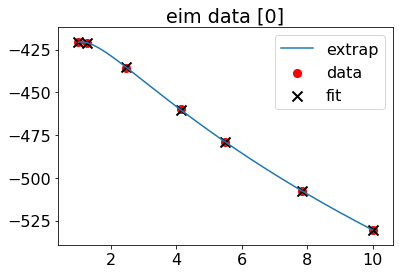

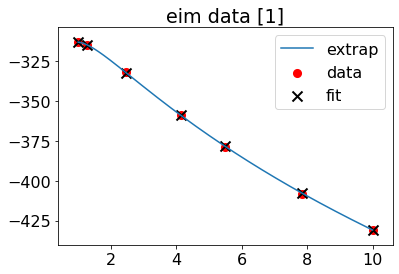

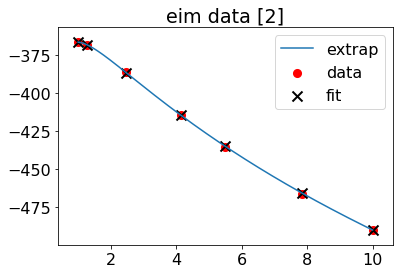

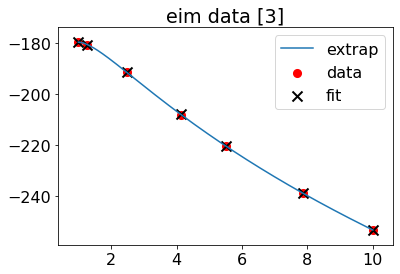

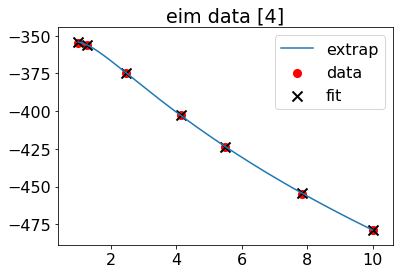

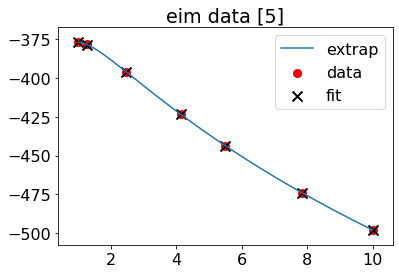

total number of greedy points = 7
worst error = 355.2255846355756
worst case = [2.00478424]


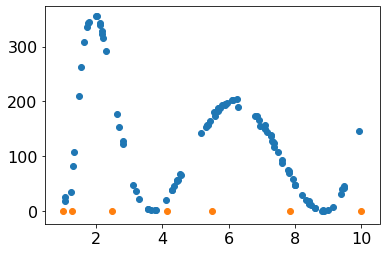

iteration = 2
step = 0, error = 3.3857318307473435e-05


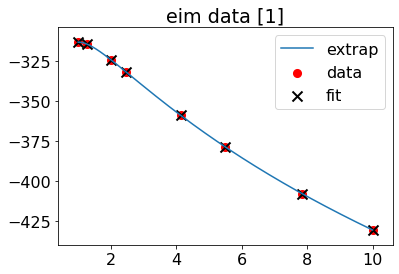

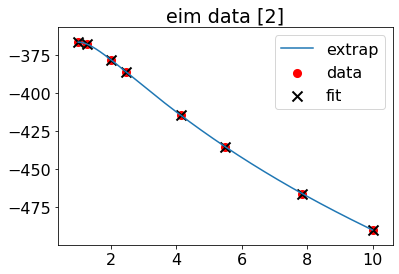

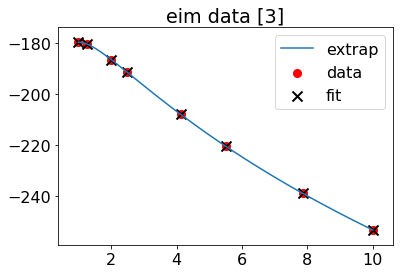

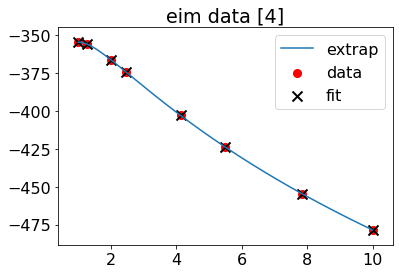

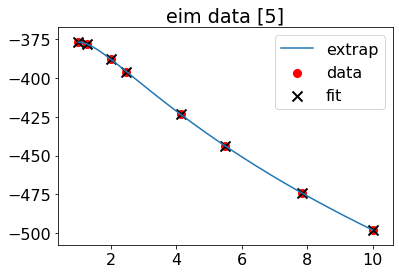

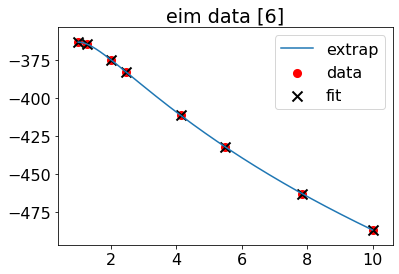

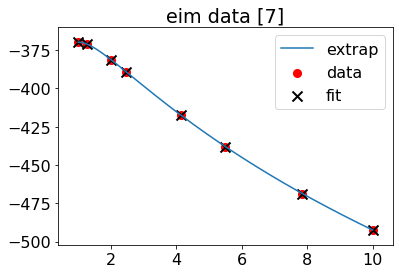

total number of greedy points = 8
worst error = 12.658243853614094
worst case = [1.42314215]


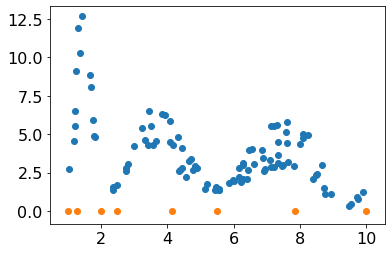

iteration = 3
step = 0, error = 9.00141832702806e-06


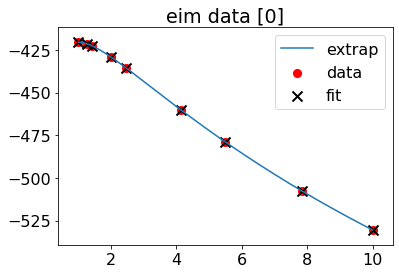

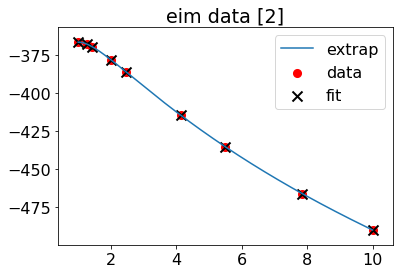

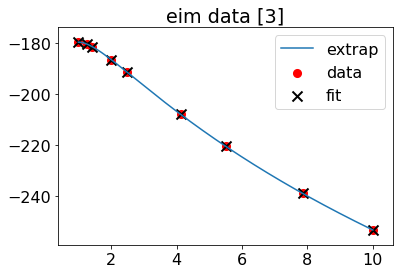

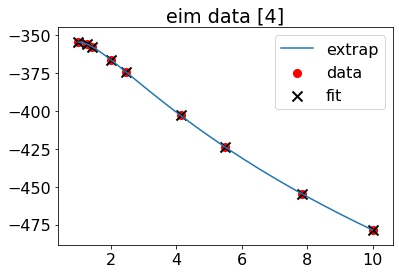

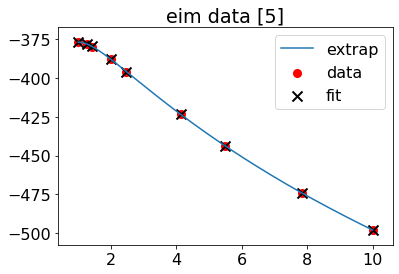

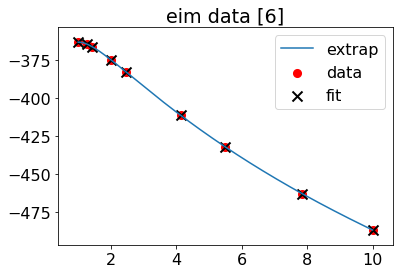

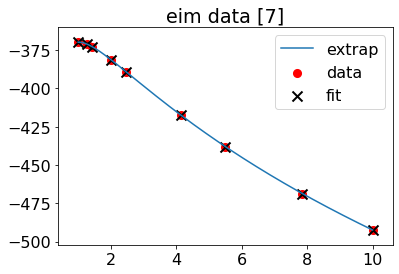

total number of greedy points = 9
worst error = 1.7612678307233065
worst case = [7.27664644]


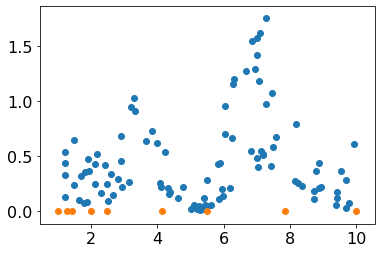

iteration = 4
step = 0, error = 2.371253310504077e-06


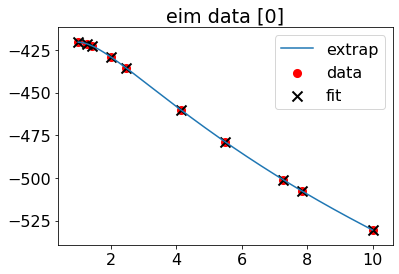

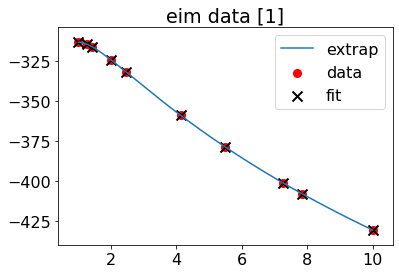

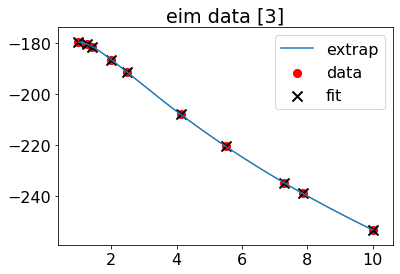

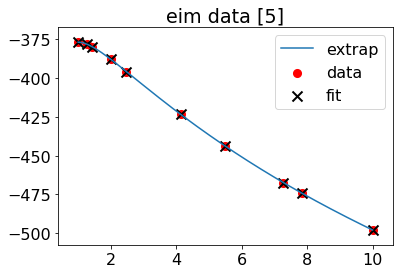

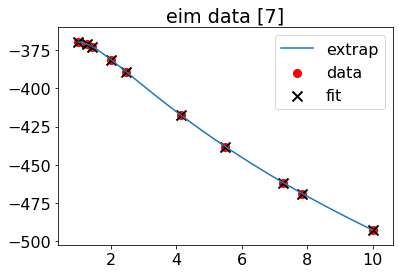

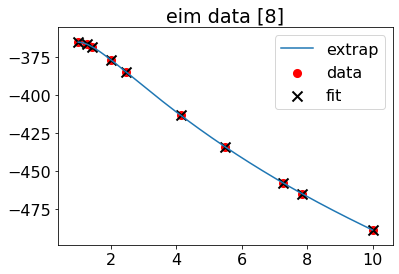

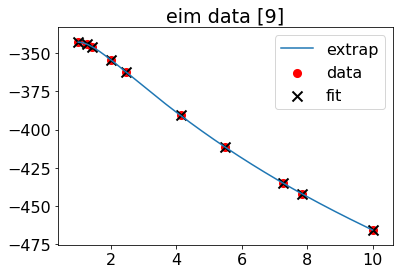

total number of greedy points = 10
worst error = 1.6614386641439514
worst case = [3.26758176]


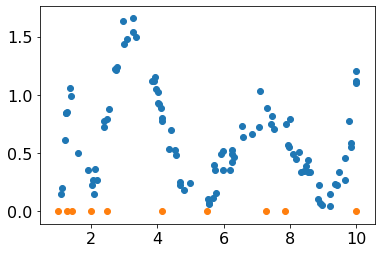

In [10]:
phase_x, phase_sur = build_surrogate_iterative(
    amp_or_phase="phase",
    qmin=1,
    qmax=10,
    qnpts=100,
    mtotal=mtotal,
    nvalidation_points=100,
    iterate_surrogate_error=True,
    max_iter=5,
    sur_model_error_tol=0.2,
    initial_greedy_tol=1e-3,
    iterated_greedy_tol=1e-12,
    fit_method='lr'
)

In [11]:
def wave_sur(q, amp_sur=amp_sur, phase_sur=phase_sur):
    
    amp = amp_sur.predict([[q]])
    phase = phase_sur.predict([[q]])
    h = amp * np.exp(-1.j * phase)
    
    return np.real(h), np.imag(h), amp, phase

In [12]:
vs_x, vs_amp, vs_phase, vt_coords = gen_1d_massratio_data([1.36], mtotal)
vs_h = vs_amp[0] * np.exp(-1.j * vs_phase[0])
vs_hp = np.real(vs_h)
vs_hc = np.imag(vs_h)

In [13]:
sur_hp, sur_hc, samp, sphase = wave_sur(1.36) 

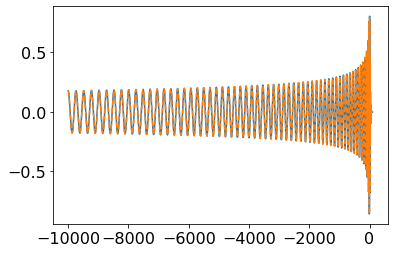

In [14]:
plt.figure()
plt.plot(vs_x, vs_hp)
plt.plot(vs_x, sur_hp, ls='--')

(-300, 100)

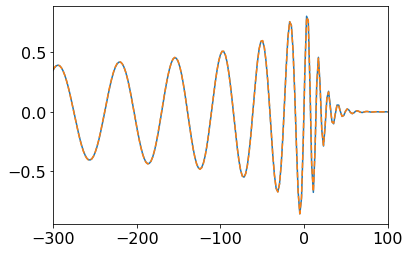

In [15]:
plt.figure()
plt.plot(vs_x, vs_hp)
plt.plot(vs_x, sur_hp, ls='--')
plt.xlim(-300,100)

In [16]:
def match(h1, h2, times):
        
    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df
    
    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)
    
    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm
    
    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)
    

    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    return ifft / h1h1 / h2h2 * 4 * dt

In [17]:
%%timeit
gen_1d_massratio_data([2], mtotal)

65.3 ms ± 800 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%timeit
wave_sur(2)

782 µs ± 9.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
(32e-3)/(897e-6)

35.67447045707915

In [19]:
778e-3/778e-6

1000.0

In [20]:
575e-3/1.2e-3

479.1666666666667

In [24]:
qs = np.linspace(1,10,100)
matches = np.zeros(len(qs))
for i in tqdm.tqdm(range(len(qs))):
    q = qs[i]
#     print(f"working q = {q}")
    vs_x, vs_amp, vs_phase, vt_coords = gen_1d_massratio_data([q], mtotal)
    vs_h = vs_amp[0] * np.exp(-1.j * vs_phase[0])
    vs_hp = np.real(vs_h)
    vs_hc = np.imag(vs_h)
    
    sur_hp, sur_hc, samp, sphase = wave_sur(q)
    
    maxmatch = np.max(np.abs(match(vs_hp, sur_hp, vs_x)))
    
    matches[i] = maxmatch

100%|██████████| 100/100 [00:08<00:00, 12.42it/s]


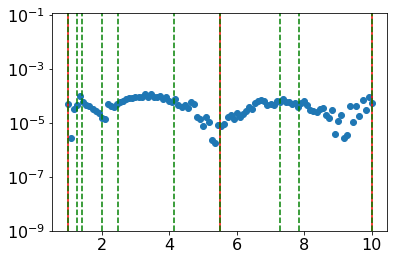

In [25]:
plt.figure()
plt.scatter(qs, 1-matches)
plt.yscale('log')
plt.ylim(1e-9)
for gp in amp_sur.grb.greedy_points:
    plt.axvline(gp, c='r')
for gp in phase_sur.grb.greedy_points:
    plt.axvline(gp, c='g', ls='--')